# Project: Deforestation Analysis in Nepal using Satellite Imagery and Deep Learning


## Introduction

This project aims to build and compare deep learning models for semantic segmentation to identify and map forest cover and deforestation in Nepal using publicly available satellite data. The goal is not only to create an accurate map but also to understand the end-to-end workflow of a geospatial deep learning project, from foundational data analysis to training and evaluating advanced neural network architectures like the U-Net.

**The core challenge:** Can we train a model on recent, high-resolution Sentinel-2 satellite imagery to predict historical forest change categories derived from the Hansen Global Forest Change dataset? This would create a powerful tool for near-real-time monitoring.



---



### Setup: Installing Libraries and Authenticating
Preparing our Google Colab environment by installing the necessary Python libraries for accessing Google Earth Engine (`earthengine-api`) and for interactive mapping (`geemap`). We also authenticate our session to grant access to the GEE platform.


In [1]:
!pip install -q earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00


In [2]:
import ee
import geemap
from google.colab import userdata

In [3]:
ee.Authenticate()

# Initialize project ID from Colab Secrets
try:
    project_id = userdata.get('GCP_PROJECT_ID')
    ee.Initialize(project=project_id)
    print("Environment is set up and Earth Engine is initialized!")
except Exception as e:
    print(e)

Environment is set up and Earth Engine is initialized!




---



## 1: Foundational Analysis with Google Earth Engine

Before diving into deep learning, it is crucial to understand our data and establish a baseline. In this phase, we use the Google Earth Engine Python API to perform a "classical" remote sensing analysis of forest change across Nepal.

### 1.1: Defining the Area of Interest (AOI) and Data
We begin by loading the Hansen Global Forest Change dataset, which provides a global, 30-meter resolution record of tree cover, loss, and gain since the year 2000. The most recent one being <i>global_forest_change_2024_v1_12</i>.


We define our AOI as the country of Nepal.

In [4]:
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
nepal_aoi = countries.filter(ee.Filter.eq('country_na', 'Nepal'))

gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')

tree_cover_2000 = gfc.select(['treecover2000'])

# Define visualization parameters - pixels with 0% cover as light yellow and 100% cover as dark green.
vis_params = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']
}

### 1.2: Visualizing Baseline Forest Cover and Loss

A visual inspection - creating an interactive map to visualize two key layers:
1.  **Tree Cover in 2000:** Our baseline, showing the extent of forests at the start of our analysis period.
2.  **Forest Loss (2000-2023):** An overlay highlighting all pixels that experienced deforestation during this period.

In [5]:
map_nepal = geemap.Map()
map_nepal.centerObject(nepal_aoi, 7) # 7 is the zoom level

# Add the tree cover layer to the map, clipping it to Nepal's borders
map_nepal.addLayer(
    tree_cover_2000.clip(nepal_aoi), # Clip the image to our AOI
    vis_params,                     # Apply our visualization style
    'Tree Cover in 2000'            # Name the layer
)

# Add the Nepal boundary to the map for context
map_nepal.addLayer(nepal_aoi.style(**{'color': 'black', 'fillColor': '00000000'}), {}, 'Nepal Border')

map_nepal


Map(center=[28.267652586988568, 83.97614162247271], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Select the forest loss band - this band is binary: 1 for loss, 0 for no loss.
forest_loss = gfc.select(['loss'])

#  .selfMask() to make all '0' pixels transparent ensures that we only see the pixels where loss actually occurred.
forest_loss_masked = forest_loss.selfMask()

# Define visualization parameters for the loss layer
loss_vis_params = {
    'palette': ['#FF0000'] # Bright Red
}

# Add the masked loss layer to our existing map object
map_nepal.addLayer(
    forest_loss_masked.clip(nepal_aoi), # Clip the layer to our AOI
    loss_vis_params,                    # Apply the red color
    'Forest Loss (2000-2023)'           # Name the layer
)

map_nepal

Map(center=[28.267652586988568, 83.97614162247271], controls=(WidgetControl(options=['position', 'transparent_…

### 1.3 Quantification of National Forest Change (2000-2023)

Visuals are insightful, but for analysis, we need numbers. We perform a quantitative analysis to calculate the total area of forest cover in 2000 and the total area of forest lost and gained up to 2023. This gives us a high-level summary of Nepal's net forest change.

<i> We define "forest" as any area with a tree canopy cover of 30% or more. </i>

In [7]:
gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')

# forest threshold (in percentage).
CANOPY_COVER_THRESHOLD = 30

# the baseline tree cover and create a forest mask
tree_cover_2000 = gfc.select(['treecover2000'])
is_forest_2000 = tree_cover_2000.gte(CANOPY_COVER_THRESHOLD) # gte = Greater Than or Equal to

# calculate the area of the forest - ee.Image.pixelArea() creates an image where each pixel's value is its area in square meters.
pixel_area_m2 = ee.Image.pixelArea()

# multiply the area image by our mask.
forest_area_m2 = is_forest_2000.multiply(pixel_area_m2)

# sum the area over the entire AOI (Nepal) - .reduceRegion() is how we get statistics from an image for a specific region.
area_stats = forest_area_m2.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=nepal_aoi.geometry(),
    scale=30,  # The native resolution of the Hansen dataset is 30 meters
    maxPixels=1e10 # Use a large number to ensure the calculation doesn't time out
)

# extract the result - from a dictionary | convert to km2
forest_area_sq_m = area_stats.get('treecover2000').getInfo()
forest_area_sq_km = forest_area_sq_m / 1e6

print(f"Using a {CANOPY_COVER_THRESHOLD}% canopy cover threshold...")
print(f"Total forest area in Nepal (Year 2000): {forest_area_sq_km:,.2f} sq km")

Using a 30% canopy cover threshold...
Total forest area in Nepal (Year 2000): 51,670.45 sq km


In [8]:
# Quantify Total Forest Loss Area (2000-2023) and Calculate Percentage
gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')

is_forest_2000 = gfc.select(['treecover2000']).gte(CANOPY_COVER_THRESHOLD)

# select the loss band and create a mask of where loss occurred
has_loss = gfc.select(['loss']).eq(1)

# combine the two conditions: was forest in 2000 AND has loss since then
actual_forest_loss = is_forest_2000.And(has_loss)

# use the pixel area image to calculate the area of the loss
pixel_area_m2 = ee.Image.pixelArea()
loss_area_m2 = actual_forest_loss.multiply(pixel_area_m2)

# sum the loss area over the entire AOI (Nepal)
loss_stats = loss_area_m2.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=nepal_aoi.geometry(),
    scale=30,
    maxPixels=1e10
)

loss_area_sq_m = loss_stats.get('treecover2000').getInfo()
loss_area_sq_km = loss_area_sq_m / 1e6

print(f"Total forest area lost in Nepal (2000-2024): {loss_area_sq_km:,.2f} sq km")

# calculate and print the percentage loss
percentage_loss = (loss_area_sq_km / forest_area_sq_km) * 100
print(f"This represents a {percentage_loss:.2f}% loss of the year 2000 forest cover.")

Total forest area lost in Nepal (2000-2024): 583.66 sq km
This represents a 1.13% loss of the year 2000 forest cover.


### 1.4 Time-Series Analysis of Annual Forest Loss

To understand the dynamics of deforestation, we analyze the `lossyear` band of the Hansen dataset. This allows us to create a time-series plot showing exactly how much forest area was lost each year, revealing trends and highlighting years with significant deforestation events.


Running calculation on Earth Engine servers... (This may take a minute)


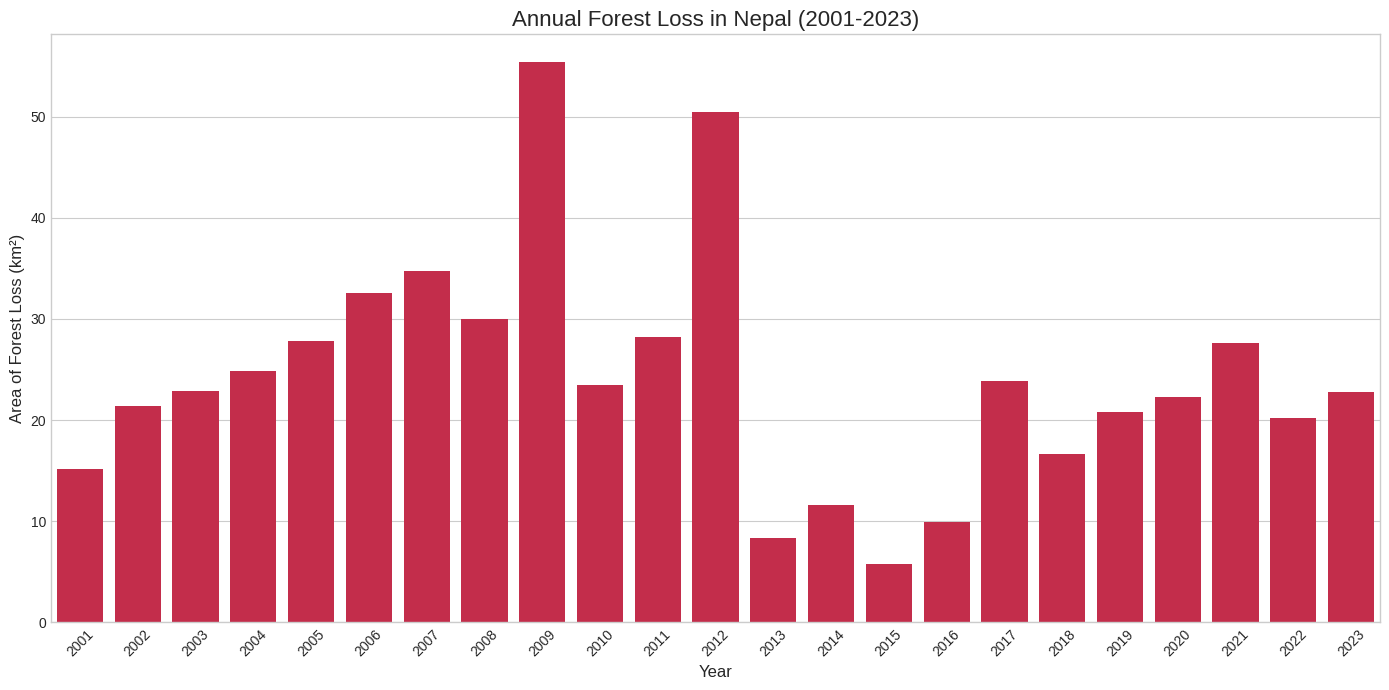

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- GEE Computation ---

gfc = ee.Image('UMD/hansen/global_forest_change_2023_v1_11')

# prepare the data for the calculation
loss_year = gfc.select(['lossyear'])
is_forest_2000 = gfc.select(['treecover2000']).gte(CANOPY_COVER_THRESHOLD)
pixel_area_m2 = ee.Image.pixelArea()

# First band is the value to sum (area), second is the group key (year).
area_by_year = pixel_area_m2.addBands(loss_year).updateMask(is_forest_2000)

# Perform a 'grouped reducer' to sum the area for each year
print("Running calculation on Earth Engine servers... (This may take a minute)")
loss_stats_by_year = area_by_year.reduceRegion(
    # *** AND THE SECOND PART OF THE FIX IS HERE ***
    reducer=ee.Reducer.sum().group(
        groupField=1,  # Group by the second band ('lossyear')
        groupName='year',
    ),
    geometry=nepal_aoi.geometry(),
    scale=30,
    maxPixels=1e10
)



# Fetch the data from GEE and convert it to a Pandas DataFrame
stats_list = loss_stats_by_year.get('groups').getInfo()

# Process the raw list of dictionaries from GEE into a clean format
loss_data = []
for item in stats_list:
    year = int(item['year']) + 2000
    # The reducer gives a 'sum' of the first band (pixel area). Convert from m^2 to km^2
    area_sq_km = item['sum'] / 1e6
    loss_data.append({'Year': year, 'Loss (sq km)': area_sq_km})

df_loss = pd.DataFrame(loss_data)
df_loss = df_loss.sort_values(by='Year')

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(x='Year', y='Loss (sq km)', data=df_loss, ax=ax, color='crimson')

ax.set_title('Annual Forest Loss in Nepal (2001-2023)', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Area of Forest Loss (km²)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5 Summary of National Forest Change in Nepal (2000-2024)

The quantitative analysis reveals the high-level dynamics of Nepal's forests over the last two decades. The key findings are:

*   **Initial Forest Area (2000):** A substantial portion of the country was forested at the beginning of the period.
*   **Total Forest Loss:** A significant area of this original forest was lost.
*   **Total Forest Gain:** Simultaneously, an impressive area of new forest was gained, often on land that was not forested in 2000.
*   **Net Change:** The final net change shows the overall trend. For Nepal, this analysis confirms the trend of **net reforestation** reported in many studies, where forest gain has outpaced forest loss over this period, largely due to successful community forestry initiatives.

This national-level summary provides the crucial context for our deep learning models, which will attempt to map these same categories at a finer, patch-based scale.

In [10]:
# Analyze forest gain
# Select the gain band and create a mask where gain has occured
gfc = ee.Image("UMD/hansen/global_forest_change_2024_v1_12")
has_gain = gfc.select(['gain']).eq(1)

# Use the pixel area to calculate the area of gain
pixel_area_m2 = ee.Image.pixelArea()
gain_area_m2 = has_gain.multiply(pixel_area_m2)

# Sum the gain area over entire Nepal AOI
gain_stats = gain_area_m2.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = nepal_aoi.geometry(),
    scale = 30,
    maxPixels = 1e10
)

gain_area_sq_m = gain_stats.get('gain').getInfo()
gain_area_sq_km = gain_area_sq_m / 1e6

In [11]:
print(f"Initial Forest Area (2000): {forest_area_sq_km:,.2f} sq km")
print("-" * 50)
print(f"Total Forest Loss (-):      {loss_area_sq_km:,.2f} sq km")
print(f"Total Forest Gain (+):      {gain_area_sq_km:,.2f} sq km")
print("-" * 50)

net_change_sq_km = gain_area_sq_km - loss_area_sq_km
final_forest_area_sq_km = forest_area_sq_km + net_change_sq_km
net_change_percentage = (net_change_sq_km / forest_area_sq_km) * 100

print(f"Net Change in Forest Area: {net_change_sq_km:,.2f} sq km")
print(f"Final Forest Area (2023):  {final_forest_area_sq_km:,.2f} sq km")

if net_change_sq_km > 0:
    print(f"\nOverall, Nepal experienced a {net_change_percentage:.2f}% NET GAIN in forest cover.")
else:
    print(f"\nOverall, Nepal experienced a {abs(net_change_percentage):.2f}% NET LOSS in forest cover.")

Initial Forest Area (2000): 51,670.45 sq km
--------------------------------------------------
Total Forest Loss (-):      583.66 sq km
Total Forest Gain (+):      134.32 sq km
--------------------------------------------------
Net Change in Forest Area: -449.34 sq km
Final Forest Area (2023):  51,221.11 sq km

Overall, Nepal experienced a 0.87% NET LOSS in forest cover.


### 1.6 Regional Analysis For FarWest Region

To validate our workflow and explore regional differences, we focus our analysis on a specific sub-region. Due to the administrative boundaries available in the stable `FAO/GAUL/2015` dataset, we use the "Far Western" Region.


In [12]:
# Defining FarWest Region as the new AOI
admin_lvl_1 = ee.FeatureCollection("FAO/GAUL/2015/level1")
farwest_aoi = admin_lvl_1.filter(ee.Filter.And(
    ee.Filter.eq('ADM0_NAME', 'Nepal'),
    ee.Filter.eq('ADM1_NAME', 'Far Western')
))

# Running the entire calculation using the AOI
gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')
pixel_area_m2 = ee.Image.pixelArea()

# Defining forest and loss/gain bands
is_forest_2000 = gfc.select(['treecover2000']).gte(CANOPY_COVER_THRESHOLD)
has_loss = gfc.select(['loss']).eq(1)
has_gain = gfc.select(['gain']).eq(1)
actual_forest_loss = is_forest_2000.And(has_loss)
# actual_forest_gain = is_forest_2000.And(has_gain)

# Calculating areas with FarWest AOI geometry
farwest_base_area = is_forest_2000.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=farwest_aoi.geometry(),
    scale=30,
    maxPixels = 1e9
).get('treecover2000').getInfo() / 1e6

farwest_loss_area = actual_forest_loss.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry = farwest_aoi.geometry(),
    scale = 30,
    maxPixels = 1e9
).get('treecover2000').getInfo() / 1e6


farwest_gain_area = has_gain.multiply(pixel_area_m2).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=farwest_aoi.geometry(),
    scale=30,
    maxPixels=1e9
).get('gain').getInfo() / 1e6

print(farwest_base_area)
print(farwest_loss_area)
print(farwest_gain_area)

8934.378883966274
98.7443078553304
20.336885883673695


In [13]:
# Summary of change
print("\n--- Summary of Forest Change in FarWest Region (2000-2024) ---")
print(f"Initial Forest Area (2000): {farwest_base_area:,.2f} sq km")
print("-" * 60)
print(f"Total Forest Loss (-):      {farwest_loss_area:,.2f} sq km")
print(f"Total Forest Gain (+):      {farwest_gain_area:,.2f} sq km")
print("-" * 60)

farwest_net_change = farwest_gain_area - farwest_loss_area
farwest_final_area = farwest_base_area + farwest_net_change
farwest_net_percentage = (farwest_net_change / farwest_base_area) * 100

print(f"Net Change in Forest Area: {farwest_net_change:,.2f} sq km")
print(f"Final Forest Area (2023):  {farwest_final_area:,.2f} sq km")
print(f"Net Percentage Change:     {farwest_net_percentage:+.2f}%")

if farwest_net_percentage > 0:
    print("\nFinding: Farwest Region shows a strong net gain in forest cover, aligning with the NASA case study.")
else:
    print("\nFinding: Farwest Region shows a net loss in forest cover overall in this period.")


--- Summary of Forest Change in FarWest Region (2000-2024) ---
Initial Forest Area (2000): 8,934.38 sq km
------------------------------------------------------------
Total Forest Loss (-):      98.74 sq km
Total Forest Gain (+):      20.34 sq km
------------------------------------------------------------
Net Change in Forest Area: -78.41 sq km
Final Forest Area (2023):  8,855.97 sq km
Net Percentage Change:     -0.88%

Finding: Farwest Region shows a net loss in forest cover overall in this period.


In [14]:
# Plotting the findings in farwest map

map_farwest = geemap.Map()
map_farwest.centerObject(farwest_aoi, 8)
map_farwest.addLayer(is_forest_2000.selfMask().clip(farwest_aoi),{'palette': 'green'}, 'Forest Cover 2000')
map_farwest.addLayer(actual_forest_loss.selfMask().clip(farwest_aoi),{'palette':'red'}, 'Forest Loss')
map_farwest.addLayer(has_gain.selfMask().clip(farwest_aoi),{'palette':'blue'}, 'Forest Gain')
map_farwest.addLayer(farwest_aoi.style(**{'color': 'black', 'fillColor': '00000000'}), {}, 'FarWest Border')

map_farwest

Map(center=[29.32388260295461, 80.9428602690115], controls=(WidgetControl(options=['position', 'transparent_bg…

## 2: Building a Baseline Deep Learning Model (SimpleFCN)

With a solid understanding of the data from our foundational analysis, we now transition to the core of the project: building a deep learning model. In this phase, we will construct a simple but effective baseline model to serve as a benchmark for more advanced architectures.





### 2.1: Preparing the Training Data Sources

Our deep learning model will learn the relationship between a modern satellite image and our historical forest change labels.
*   **Input Image (X):** We use recent (late 2023), cloud-free Sentinel-2 imagery, which provides 10-meter resolution data across multiple spectral bands (Red, Green, Blue, and Near-Infrared).
*   **Label Mask (y):** We use the Hansen dataset to create a single "ground truth" layer with three distinct classes: `0` for Stable Non-Forest, `1` for Stable Forest (since 2000), and `2` for Deforested Land (forest in 2000 that was later lost).

Mount Drive & Define Data Sources






In [15]:
import os
from google.colab import drive

In [16]:
# Mount Google Drive
# prompt for authorization.
drive.mount('/content/drive')
print("Drive mounted successfully.")

Mounted at /content/drive
Drive mounted successfully.


In [17]:
PROJECT_FOLDER = '/content/drive/My Drive/PyTorch_Forest_Project'
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)
    print(f"Created project folder: {PROJECT_FOLDER}")

In [18]:
# Image Source: A recent, cloud-free Sentinel-2 mosaic

s2_image = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(nepal_aoi)
              .filterDate('2024-10-01', '2024-12-31') # post-monsoon to minimize clouds
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .median() # median() is combine images and remove clouds/shadows
              .select(['B4', 'B3', 'B2', 'B8'])) # Red, Green, Blue, Near-Infrared (NIR)

In [19]:
# Label Source with Hansen Dataset

gfc = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')

# For our label, let's create a single-band image: 0=Non-Forest, 1=Forest, 2=Lost Forest
is_forest_2000 = gfc.select('treecover2000').gte(30)
has_loss = gfc.select('loss').eq(1)


# Create the label image: Start with non-forest (0), add forest (1), then overwrite with loss (2)
# .where(condition, value) : if-statement for each pixel
label = (ee.Image(0)
         .where(is_forest_2000, 1)
         .where(is_forest_2000.And(has_loss), 2)
         .rename('label')) # Rename the band to 'label' for clarity

print("\nDefined our Sentinel-2 image source and created our categorical label image.")


Defined our Sentinel-2 image source and created our categorical label image.


### 2.2: Exporting Labeled Image Patches

We cannot process the entire country at once. Instead, we generate thousands of random sample points across Nepal. For each point, we export a small 64x64 pixel "chip" of both the Sentinel-2 input image and the corresponding label mask. These chips are saved as GeoTIFF files to Google Drive, forming the raw dataset for our model.



In [20]:
# Define Sampling and Export Parameters
NUM_SAMPLES = 5000
PATCH_SIZE = 64     # The dimension (in pixels) of the square chips to export
SCALE = 10          # The resolution (in meters) to export at. Sentinel-2 is 10m.
START_INDEX = 4999  # Use 0 for starting - adjust if interruption occurs from last file

# Base filename for our output files
FILE_PREFIX = 'nepal_forest_patch'

# Generate Random Points for Sampling
sample_points = ee.FeatureCollection.randomPoints(
    region=nepal_aoi.geometry(),
    points=NUM_SAMPLES,
    seed=42  # seed for reproducibility
)
print(f"Generated {NUM_SAMPLES} random sample points across Nepal.")

# Combine Image and Label into a Single Export Image - stack our bands: [B4, B3, B2, B8, label]. All will be in one file.
export_image = s2_image.addBands(label).toFloat() # toFloat() for compatibility

# Launch the Export Tasks -> GEE Tasks tab to monitor
print("\nStarting the export process...")
print("Go to https://code.earthengine.google.com/ and check the 'Tasks' tab to run them.")

# Create a list of all features to avoid repeatedly calling .toList()
points_list = sample_points.toList(NUM_SAMPLES)

for i in range(START_INDEX, NUM_SAMPLES):
    point = ee.Feature(points_list.get(i))

    # Create a unique filename for each patch
    filename = f'{FILE_PREFIX}_{i:04d}'

    # Define the export task for this specific patch
    task = ee.batch.Export.image.toDrive(
        image=export_image,
        description=f'GeoTIFF_Export_{filename}',
        folder='PyTorch_Forest_Project', # The folder we created in Google Drive
        fileNamePrefix=filename,
        region=point.geometry().buffer(PATCH_SIZE * SCALE / 2, 1).bounds(),
        scale=SCALE,
        fileFormat='GeoTIFF'
    )

    task.start()

print(f"\nSuccessfully LAUNCHED {NUM_SAMPLES} export tasks as GeoTIFF files.")
print("Please go to the GEE Tasks tab to monitor and run them. This will take some time.")

Generated 5000 random sample points across Nepal.

Starting the export process...
Go to https://code.earthengine.google.com/ and check the 'Tasks' tab to run them.

Successfully LAUNCHED 5000 export tasks as GeoTIFF files.
Please go to the GEE Tasks tab to monitor and run them. This will take some time.


### 2.3: Building the PyTorch Data Pipeline

To feed data to our model efficiently, we create a custom PyTorch `Dataset` class. This class handles the logic for finding our GeoTIFF files, reading them, performing necessary pre-processing (like center-cropping to ensure uniform size), and converting them into PyTorch tensors. We then wrap this `Dataset` in a `DataLoader` to handle batching, shuffling, and parallel data loading.

In [21]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 83.7 MB/s eta 0:00:00


In [22]:
import os
import torch
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [23]:
class ForestDataset(Dataset):
    """Custom PyTorch Dataset for our forest GeoTIFF patches."""

    def __init__(self, root_dir, target_size = 64):
        """
        Args:
            root_dir (string): Directory with all the GeoTIFF images.
        """
        self.root_dir = root_dir
        self.target_size = target_size
        # Create a list of all .tif files in the directory
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tif')]

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index.
        This is where we read the file, separate image and label, and convert to tensors.
        """
        # Construct the full file path
        img_path = os.path.join(self.root_dir, self.image_files[idx])

        # Read the GeoTIFF file using rasterio
        with rasterio.open(img_path) as dataset:
            # .read() loads all bands into a NumPy array with shape (bands, height, width) - (5, 64, 64)
            numpy_array = dataset.read()

        # Enforce uniform size with a center crop - Get the current height and width of the loaded image
        _, h, w = numpy_array.shape

        # If the image is larger than our target (assume always >= target)
        if h > self.target_size or w > self.target_size:
            top = (h - self.target_size) // 2
            left = (w - self.target_size) // 2
            numpy_array = numpy_array[:, top:top + self.target_size, left:left + self.target_size]


        # Separate the input image (X) and the label mask (y)
        # The first 4 bands are our Sentinel-2 data (B4, B3, B2, B8)
        image_numpy = numpy_array[:4, :, :]
        # The 5th band is our label mask (0, 1, or 2)
        label_numpy = numpy_array[4, :, :]

        #  Convert NumPy arrays to PyTorch Tensors - Input images should be float for model computations
        image_tensor = torch.from_numpy(image_numpy).to(torch.float32)
        # Labels for classification should be long integers
        label_tensor = torch.from_numpy(label_numpy).to(torch.long)

        return image_tensor, label_tensor

### 2.4: Designing the Baseline CNN Model (SimpleFCN)

Our first model is a Simple Fully Convolutional Network (FCN). This is a standard CNN architecture that preserves spatial dimensions from input to output, making it suitable for semantic segmentation. It consists of several blocks of `Convolution -> Batch Normalization -> ReLU` layers that extract features, followed by a final `1x1 convolution` that acts as a pixel-wise classifier.

In [24]:
import torch
import torch.nn as nn

In [25]:
class simpleFCN(nn.Module):
  def __init__(self, in_channels, num_classes):
      """
        Args:
            in_channels (int): Number of channels in the input image (4 for us: R,G,B,NIR).
            num_classes (int): Number of output classes (3 for us: Non-Forest, Forest, Deforested).
      """
      super(simpleFCN, self).__init__()

      # --- The "Encoder" Path ---
      # We create a series of blocks that extract features.
      # The padding='same' argument is crucial ensures that the output  height and width are the same as the input height and width.

      # Block 1: Input -> 16 channels
      self.block1 = nn.Sequential(
          nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True)
      )

      # Block 2: 16 -> 32 channels
      self.block2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=3, padding='same'),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True)
      )

      # Block 3: 32 -> 64 channels
      self.block3 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=3, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True)
      )

      # The Final Classifier Layer
      # This 1x1 convolution acts as a pixel-wise classifier.
      # It takes the 64 feature channels and condenses them down to
      # 3 output channels, one for each class score.
      self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
      """The forward pass defines how data flows through the network."""
      # Pass input through the encoder blocks
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)

      # Pass through the final classifier
      x = self.final_conv(x)

      return x

In [26]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader,
                scheduler, num_epochs, patience, checkpoint_path):
    """
    A master function to handle the complete training and validation loop.

    Args:
        model (torch.nn.Module): The neural network model to train.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler. Can be None.
        num_epochs (int): The maximum number of epochs to train for.
        patience (int): The patience for early stopping.
        checkpoint_path (str): The file path to save/load checkpoints.

    Returns:
        tuple: A tuple containing:
            - model (torch.nn.Module): The model with the best weights loaded.
            - train_loss_history (list): A list of average training losses per epoch.
            - val_loss_history (list): A list of average validation losses per epoch.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting training on device: {device}")
    model.to(device)

    # Checkpointing Logic
    start_epoch, best_val_loss, epochs_no_improve = 0, float('inf'), 0
    train_loss_history, val_loss_history = [], []
    if os.path.exists(checkpoint_path):
        print(f"Resuming training from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        epochs_no_improve = checkpoint['epochs_no_improve']
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    else:
        print("Starting new training run.")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping condition already met at loaded checkpoint (Patience: {epochs_no_improve}/{patience}).")
        print("Skipping training loop.")
        return model, train_loss_history, val_loss_history

    best_model_weights = model.state_dict().copy()

    # The training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [T]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(avg_val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"  -> Learning rate reduced from {old_lr} to {new_lr}")

        if avg_val_loss < best_val_loss:
            best_val_loss, epochs_no_improve = avg_val_loss, 0
            best_model_weights = model.state_dict().copy()
            print("  -> Validation loss improved!")
        else:
            epochs_no_improve += 1
            print(f"  -> No improvement. Patience: {epochs_no_improve}/{patience}")

        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss,
            'train_loss_history': train_loss_history, 'val_loss_history': val_loss_history,
            'epochs_no_improve': epochs_no_improve,
        }, checkpoint_path)

        if epochs_no_improve >= patience:
            print("\nEarly stopping triggered!"); break

    print("\nTraining complete. Loading best model weights.")
    model.load_state_dict(best_model_weights)

    return model, train_loss_history, val_loss_history

In [ ]:
# This dictionary will be populated by the analysis cell of each experiment
# We initialize it here to ensure it's created only once per session.
all_results = {}

In [27]:
import torch.optim as optim
from tqdm.notebook import tqdm # progress bar
from torch.utils.data import random_split

In [28]:
# Instantiate our custom dataset
dataset = ForestDataset(root_dir=PROJECT_FOLDER)
print(f"Found {len(dataset)} total samples.")

BATCH_SIZE = 64

# Instantiate the model
model = simpleFCN(in_channels = 4, num_classes = 3)

# Prepare datasets and dataloaders

# Define the split ratio
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # fixed seed for reproducability
)

print(f"  - Training samples:   {len(train_dataset)}")
print(f"  - Validation samples: {len(val_dataset)}")
print(f"  - Test samples:       {len(test_dataset)}")

# Create dataset for both sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Found 5000 total samples.
  - Training samples:   3500
  - Validation samples: 750
  - Test samples:       750


### Training and Evaluating the Baseline Model

We train the `SimpleFCN` using a robust training loop that includes a train/validation/test split, early stopping to prevent overfitting, and checkpointing to save progress. We evaluate the final model using a comprehensive set of metrics, including Overall Accuracy, Precision, Recall, F1-Score, and Intersection over Union (IoU), to get a complete picture of its performance.

Baseline FCN 
Starting training on device: cuda
Resuming training from /content/drive/My Drive/PyTorch_Forest_Project/training_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Saving final model to /content/drive/My Drive/PyTorch_Forest_Project/best_baseline_fcn_model.pth
Model saved successfully.


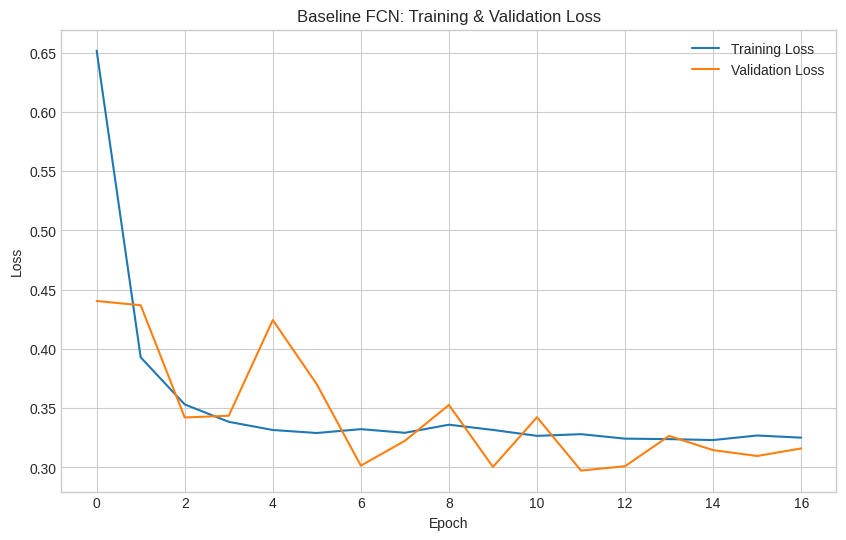

In [29]:
# Baseline FCN (Unweighted Loss)
print("Baseline FCN ")

# Define all components
baseline_fcn = simpleFCN(in_channels=4, num_classes=3)
baseline_optimizer = optim.Adam(baseline_fcn.parameters(), lr=0.001)
baseline_criterion = nn.CrossEntropyLoss() # Standard, unweighted loss
baseline_chk_path = os.path.join(PROJECT_FOLDER, 'training_checkpoint.pth')
baseline_final_path = os.path.join(PROJECT_FOLDER, 'best_baseline_fcn_model.pth')

# Call the master training function
baseline_fcn, baseline_train_hist, baseline_val_hist = train_model(
    model=baseline_fcn,
    criterion=baseline_criterion,
    optimizer=baseline_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=None,
    num_epochs=25,
    patience=5,
    checkpoint_path=baseline_chk_path
)

# Save the final best model
print(f"\nSaving final model to {baseline_final_path}")
torch.save(baseline_fcn.state_dict(), baseline_final_path)
print("Model saved successfully.")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(baseline_train_hist, label='Training Loss')
plt.plot(baseline_val_hist, label='Validation Loss')
plt.title('Baseline FCN: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
from tqdm.notebook import tqdm
import random

def evaluate_model(model, model_name, test_loader, device, all_results_dict):
    """
    A master function to perform a complete evaluation (metrics and visualization)
    on a trained model, print a detailed report, and store a curated summary.
    """
    print(f"--- Starting Comprehensive Evaluation for: {model_name} ---")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images); _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy().flatten())
            all_labels.append(labels.cpu().numpy().flatten())
    all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)

    # Calculate Metrics
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    overall_accuracy = 100 * np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

    class_names = ["Non-Forest", "Forest", "Deforested"]
    precisions, recalls, f1_scores, ious = [], [], [], []

    # Print Detailed Per-Class Report
    print("\n--- Detailed Per-Class Metrics ---")
    for i in range(len(class_names)):
        TP = conf_matrix[i, i]; FP = np.sum(conf_matrix[:, i]) - TP; FN = np.sum(conf_matrix[i, :]) - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        precisions.append(precision); recalls.append(recall); f1_scores.append(f1); ious.append(iou)

        print(f"\nClass: {class_names[i]} (Class {i})")
        print(f"  - Precision: {precision:.3f}")
        print(f"  - Recall:    {recall:.3f}")
        print(f"  - F1-Score:  {f1:.3f}")
        print(f"  - IoU:       {iou:.3f}")

    # Print Summary Metrics
    print("\n" + "-" * 30)
    print("--- Summary Metrics ---")
    print(f"Overall Pixel Accuracy: {overall_accuracy:.2f}%")
    print(f"Macro-Averaged F1-Score: {np.mean(f1_scores):.3f}")
    print(f"Mean IoU (mIoU):         {np.mean(ious):.3f}")
    print("-" * 60)

    # Store Curated Results for Final Comparison Table
    all_results_dict[model_name] = {
        "Overall Accuracy": f"{overall_accuracy:.2f}%", "Mean IoU (mIoU)": f"{np.mean(ious):.3f}",
        "Macro F1-Score": f"{np.mean(f1_scores):.3f}", "F1: Non-Forest": f"{f1_scores[0]:.3f}",
        "F1: Forest": f"{f1_scores[1]:.3f}", "F1: Deforested": f"{f1_scores[2]:.3f}",
        "Recall: Deforested": f"{recalls[2]:.3f}", "Precision: Deforested": f"{precisions[2]:.3f}",
    }
    print(f"\nCurated results for '{model_name}' have been stored for the final comparison table.")

    return all_results_dict

def visualize_predictions(dataset, model, device, model_name, num_samples=3):
    """A master function to visualize model predictions on random samples."""
    print(f"\n--- Starting Qualitative Visualization for: {model_name} ---")
    color_map = np.array([[0, 0, 0], [0, 0.8, 0], [1, 0, 0]], dtype=np.float32)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    fig.suptitle(f'Prediction Analysis for: {model_name}', fontsize=16)
    model.eval()
    for i in range(num_samples):
        sample_idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[sample_idx]
        rgb_image = image.numpy()[:3, :, :].transpose(1, 2, 0)
        p2, p98 = np.percentile(rgb_image, (2, 98)); rgb_image_stretched = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)
        label_viz = color_map[label.numpy()]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device)); _, predicted = torch.max(output, 1)
        predicted_viz = color_map[predicted.cpu().squeeze().numpy()]
        axes[i, 0].imshow(rgb_image_stretched); axes[i, 0].set_title(f'Input (Sample #{sample_idx})'); axes[i, 0].axis('off')
        axes[i, 1].imshow(label_viz); axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')
        axes[i, 2].imshow(predicted_viz); axes[i, 2].set_title('Model Prediction'); axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Call the evaluation function (it also stores the results)
all_results = evaluate_model(
    model=baseline_fcn,
    model_name="Baseline FCN",
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)

--- Starting Comprehensive Evaluation for: Baseline FCN ---


Testing Baseline FCN:   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.892
  - Recall:    0.937
  - F1-Score:  0.914
  - IoU:       0.842

Class: Forest (Class 1)
  - Precision: 0.833
  - Recall:    0.743
  - F1-Score:  0.786
  - IoU:       0.647

Class: Deforested (Class 2)
  - Precision: 0.000
  - Recall:    0.000
  - F1-Score:  0.000
  - IoU:       0.000

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 87.62%
Macro-Averaged F1-Score: 0.567
Mean IoU (mIoU):         0.496
------------------------------------------------------------

Curated results for 'Baseline FCN' have been stored for the final comparison table.



--- Starting Qualitative Visualization for: Baseline FCN ---


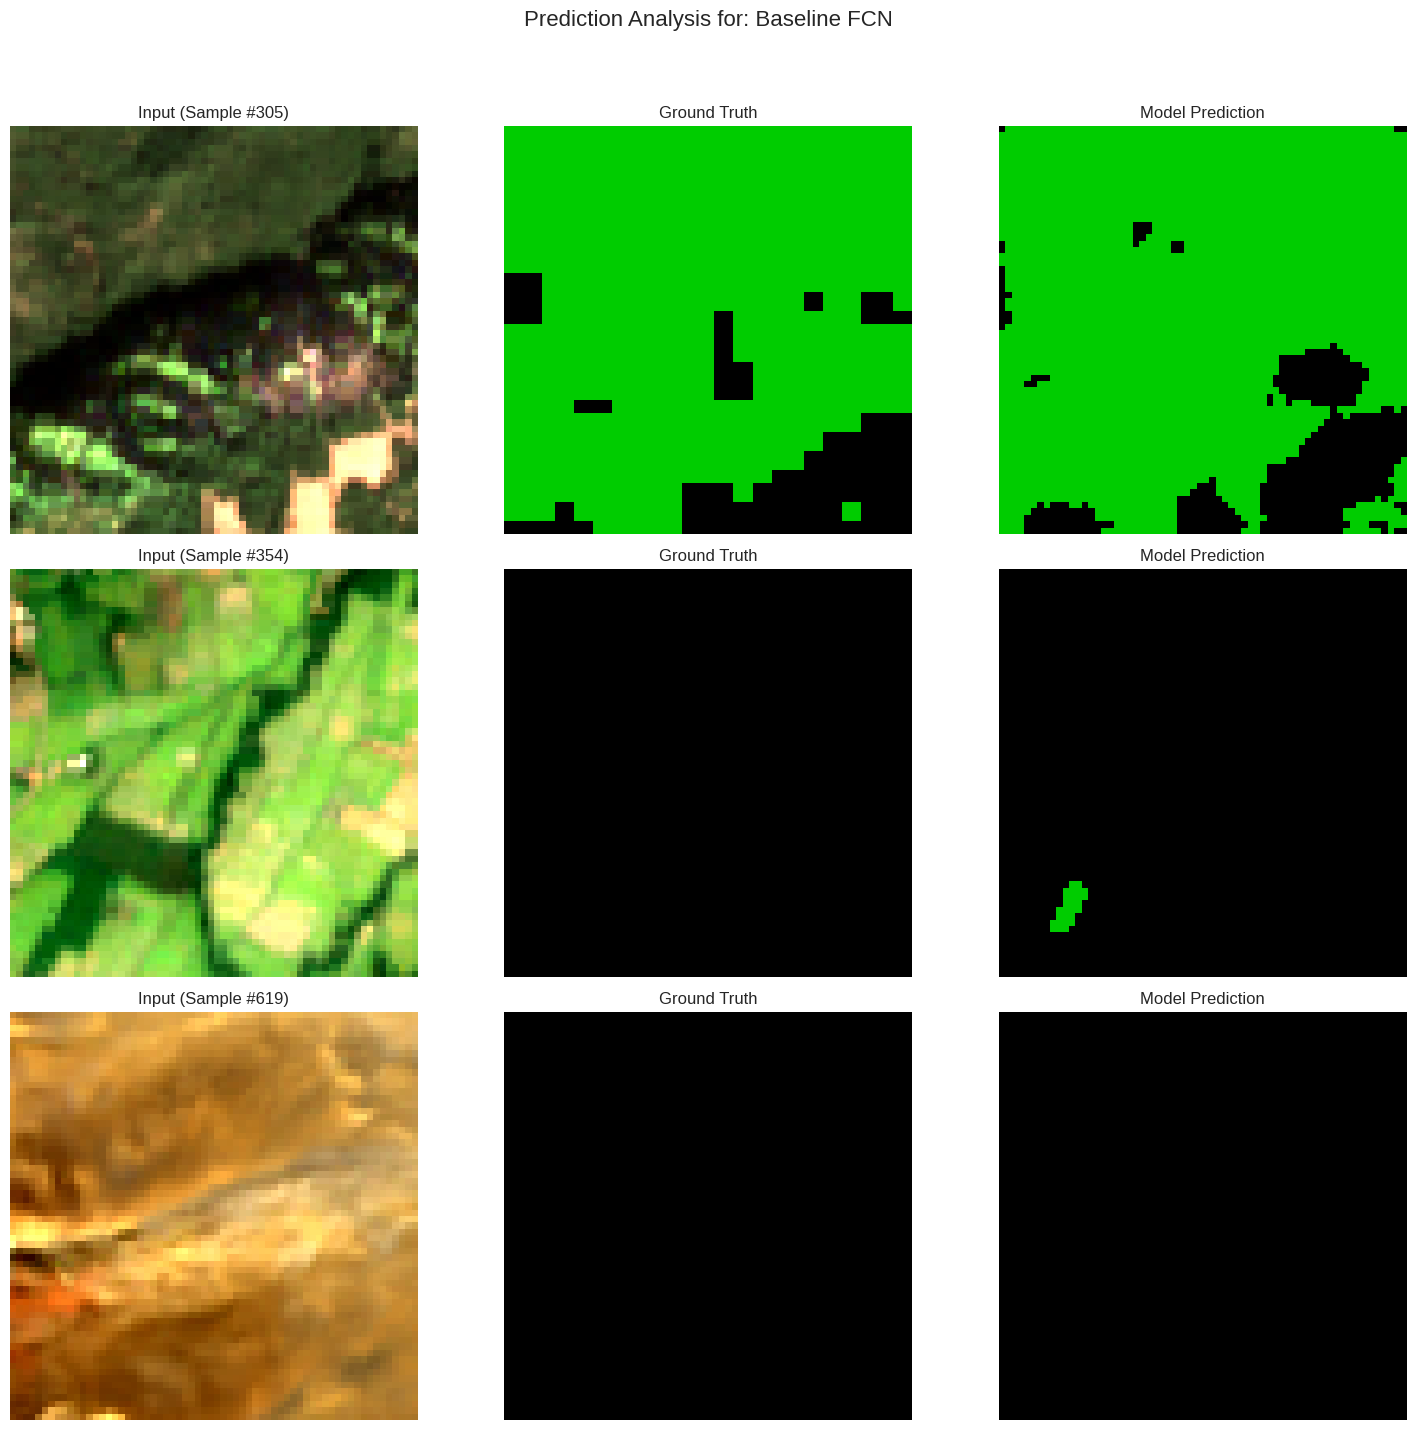

In [32]:
# Call the visualization function
visualize_predictions(
    dataset=test_dataset,
    model=baseline_fcn,
    device=device,
    model_name="Baseline FCN"
)

## 3: Comparative Analysis and Model Improvement

The results from our baseline model revealed a critical weakness: a complete failure to identify the rare "Deforested" class due to severe class imbalance. In this phase, we will implement and compare different strategies to solve this problem and improve overall performance.



### 3.1: Diagnosing and Addressing Class Imbalance

Our first experiment is to tackle the class imbalance directly. We analyze our training dataset to calculate the precise frequency of each class. Based on this, we compute inverse frequency weights, which we will use in a `WeightedCrossEntropyLoss` function. This heavily penalizes mistakes made on the rare classes, forcing the model to pay attention to them.

In [33]:
import torch
import numpy as np
from tqdm.notebook import tqdm

# Define the path for our saved weights file
WEIGHTS_FILE_PATH = os.path.join(PROJECT_FOLDER, 'class_weights.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if weights file exists
if os.path.exists(WEIGHTS_FILE_PATH):
    # load it and skip the calculation
    print(f"Found existing weights file. Loading from: {WEIGHTS_FILE_PATH}")
    class_weights_tensor = torch.load(WEIGHTS_FILE_PATH, map_location=device)

else:
    # If it does not exist, perform the calculation and save the result
    print("Weights file not found. Calculating class frequencies from the training dataset...")

    # We use the train_dataset to calculate weights with temporary DataLoader and a large batch size
    weight_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

    print("Calculating class frequencies from the training dataset...")
    # Initialize a dictionary to hold the pixel counts for each class
    class_pixel_counts = {0: 0, 1: 0, 2: 0}

    # Loop through the entire training set
    for _, labels in tqdm(weight_loader, desc="Counting Pixels"):
        # For each batch of labels, count the occurrences of each class value
        unique, counts = np.unique(labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            if u in class_pixel_counts:
                class_pixel_counts[u] += c

    print("\n--- Class Distribution Analysis ---")
    total_pixels = sum(class_pixel_counts.values())
    print(f"Total pixels in training set: {total_pixels:,}")

    class_names = ["0: Non-Forest", "1: Forest", "2: Deforested"]
    class_weights = []

    for i in range(len(class_names)):
        frequency = class_pixel_counts[i] / total_pixels
        # Calculate weight as inverse of frequency
        weight = 1.0 / (frequency + 1e-6) # Add epsilon to avoid division by zero
        class_weights.append(weight)

        print(f"  - {class_names[i]}: {class_pixel_counts[i]:,} pixels ({frequency:.4%})")

    # Normalize the weights so they aren't astronomically large
    class_weights = np.array(class_weights)
    class_weights = class_weights / np.sum(class_weights)

    print("\n--- Final Calculated Weights ---")
    for i in range(len(class_names)):
        print(f"  - {class_names[i]}: {class_weights[i]:.4f}")

    # Convert weights to a PyTorch tensor to be used in the loss function
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print("\nClass weights tensor created and ready for use in the loss function.")

    # save the weight tensor to class_weights file
    WEIGHTS_FILE_PATH = os.path.join(PROJECT_FOLDER, 'class_weights.pth')

    print(f"\nSaving class weights to: {WEIGHTS_FILE_PATH}")
    torch.save(class_weights_tensor, WEIGHTS_FILE_PATH)
    print("Weights saved successfully.")

Found existing weights file. Loading from: /content/drive/My Drive/PyTorch_Forest_Project/class_weights.pth


### 3.2: Re-training the FCN with Weighted Loss

To isolate the effect of our intervention, we re-train the exact same `SimpleFCN` architecture from scratch, but this time using our new weighted loss function. This allows us to scientifically measure the impact of this single change on model performance, particularly on the "Deforested" class.

--- Starting Experiment 2: Weighted FCN ---
Starting training on device: cuda
Resuming training from /content/drive/My Drive/PyTorch_Forest_Project/weighted_fcn_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Saving final model to /content/drive/My Drive/PyTorch_Forest_Project/best_weighted_fcn_model.pth
Model saved successfully.


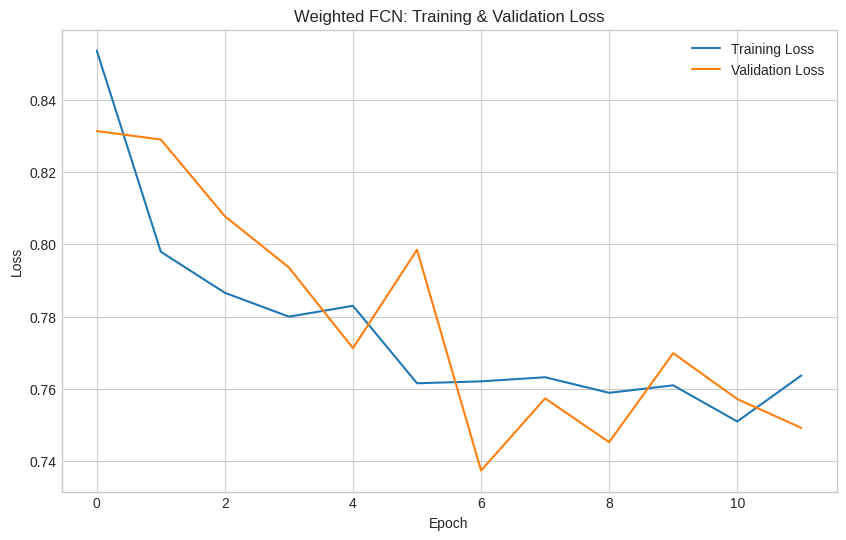

In [34]:
# FCN with Weighted Loss ---
print("--- Starting Experiment 2: Weighted FCN ---")

weighted_fcn = simpleFCN(in_channels=4, num_classes=3)
weighted_fcn_optimizer = optim.Adam(weighted_fcn.parameters(), lr=0.001)

# weighted criterion
weighted_fcn_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
weighted_fcn_chk_path = os.path.join(PROJECT_FOLDER, 'weighted_fcn_checkpoint.pth')
weighted_fcn_final_path = os.path.join(PROJECT_FOLDER, 'best_weighted_fcn_model.pth')

# call the master training function
weighted_fcn, weighted_fcn_train_hist, weighted_fcn_val_hist = train_model(
    model=weighted_fcn,
    criterion=weighted_fcn_criterion,
    optimizer=weighted_fcn_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=None, # No scheduler for this run
    num_epochs=25,
    patience=5,
    checkpoint_path=weighted_fcn_chk_path
)

# save the final best model
print(f"\nSaving final model to {weighted_fcn_final_path}")
torch.save(weighted_fcn.state_dict(), weighted_fcn_final_path)
print("Model saved successfully.")

# plot the results for this experiment
plt.figure(figsize=(10, 6))
plt.plot(weighted_fcn_train_hist, label='Training Loss')
plt.plot(weighted_fcn_val_hist, label='Validation Loss')
plt.title('Weighted FCN: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
model_name_exp2 = "Weighted FCN"
model_path_exp2 = os.path.join(PROJECT_FOLDER, 'best_weighted_fcn_model.pth')

# Load the trained model
model_exp2 = simpleFCN(in_channels=4, num_classes=3)
model_exp2.load_state_dict(torch.load(model_path_exp2, map_location=device))
model_exp2.to(device)

# Call the master evaluation function (it prints, stores results)
all_results = evaluate_model(
    model=model_exp2,
    model_name=model_name_exp2,
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
)

--- Starting Comprehensive Evaluation for: Weighted FCN ---


Testing Weighted FCN:   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.982
  - Recall:    0.639
  - F1-Score:  0.774
  - IoU:       0.631

Class: Forest (Class 1)
  - Precision: 0.776
  - Recall:    0.796
  - F1-Score:  0.786
  - IoU:       0.647

Class: Deforested (Class 2)
  - Precision: 0.006
  - Recall:    0.454
  - F1-Score:  0.011
  - IoU:       0.006

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 68.52%
Macro-Averaged F1-Score: 0.524
Mean IoU (mIoU):         0.428
------------------------------------------------------------

Curated results for 'Weighted FCN' have been stored for the final comparison table.



--- Starting Qualitative Visualization for: Weighted FCN ---


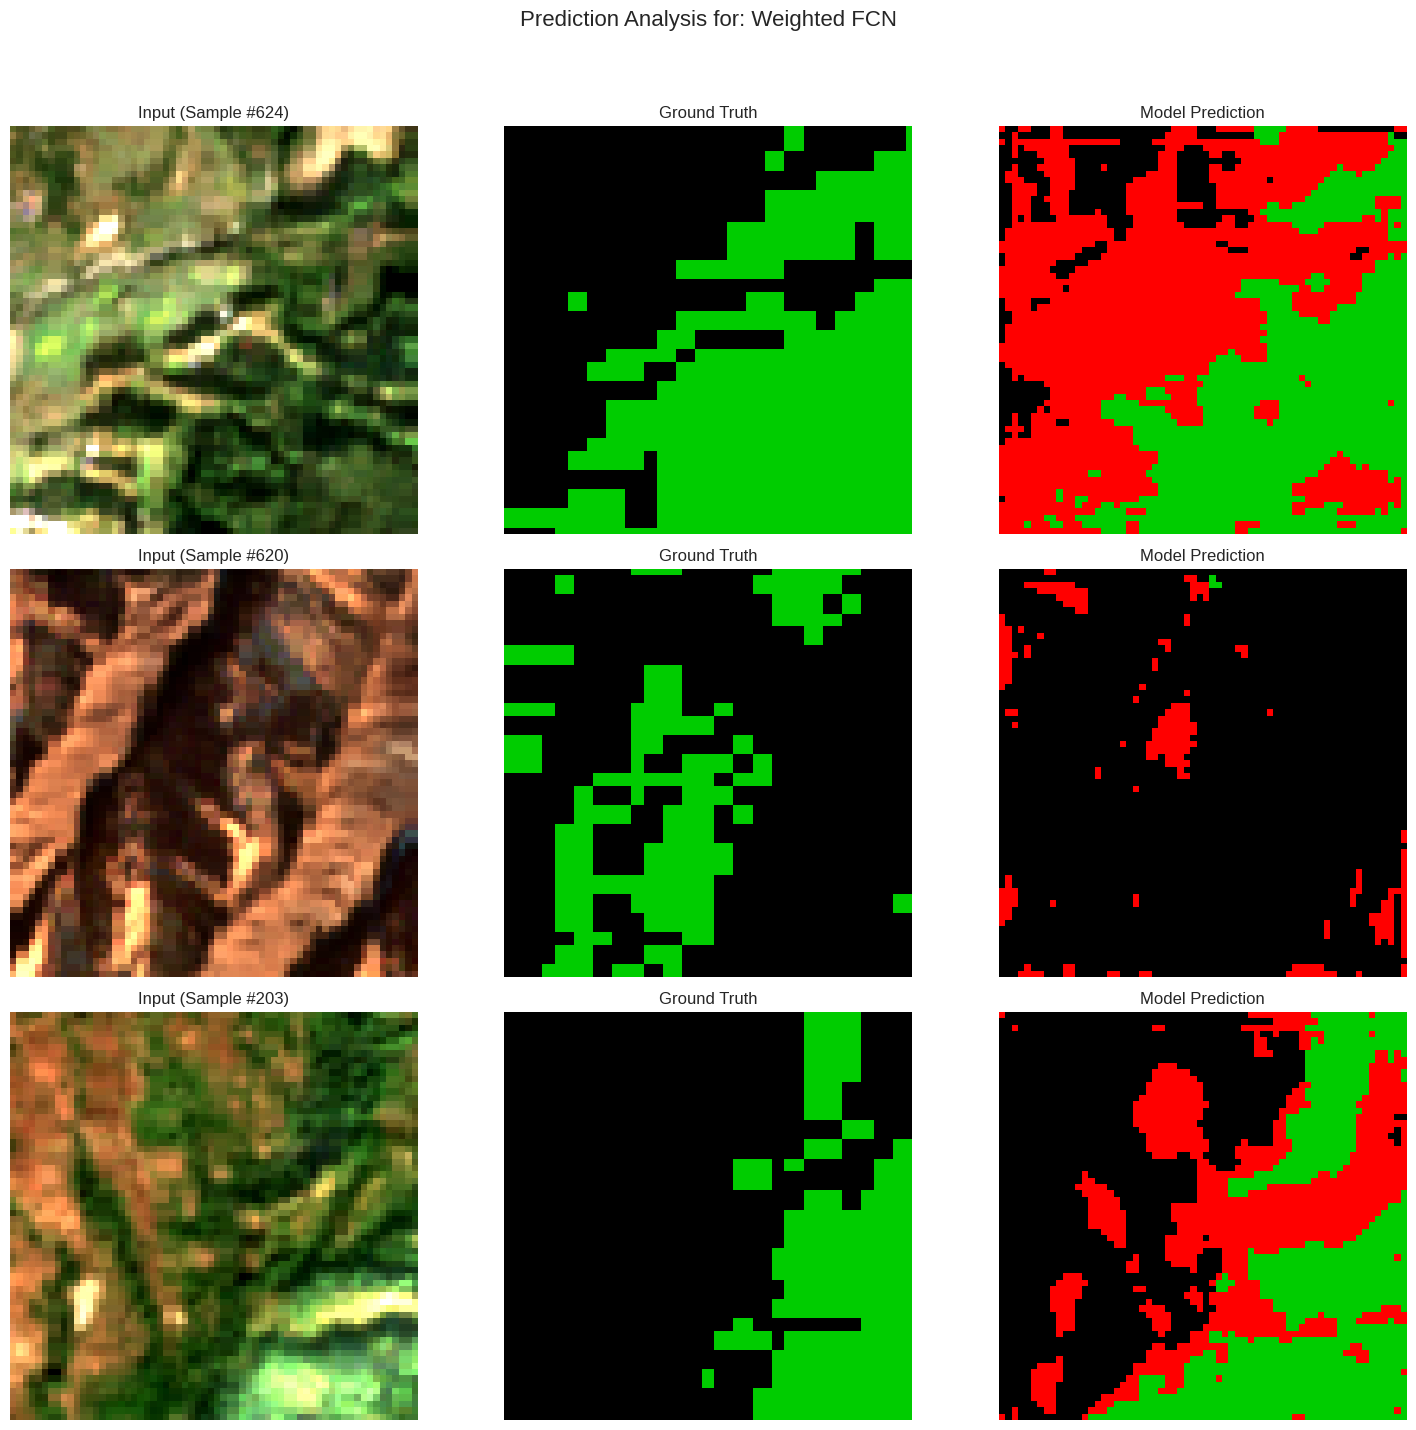

In [36]:
# Call the master visualization function
visualize_predictions(
    dataset=test_dataset,
    model=model_exp2,
    device=device,
    model_name=model_name_exp2
)

### 3.3: Designing an Advanced Architecture (U-Net)

Our analysis showed that while weighted loss helped the FCN *detect* the rare class, its predictions were spatially noisy. To address this, we now implement a more advanced architecture: the **U-Net**. The U-Net's encoder-decoder structure with skip connections is the industry standard for semantic segmentation and is specifically designed to produce clean, spatially precise prediction maps.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """A helper module with two convolutions: (conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """The U-Net architecture for semantic segmentation."""
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()

        # --- Encoder (Downsampling Path) ---
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # --- Decoder (Upsampling Path) ---
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256) # 256 from upsample + 256 from skip

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128) # 128 from upsample + 128 from skip

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64) # 64 from upsample + 64 from skip

        # --- Final Classifier Layer ---
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)     # -> 64x64x64
        x2 = self.down1(x1)  # -> 32x32x128
        x3 = self.down2(x2)  # -> 16x16x256
        x4 = self.down3(x3)  # -> 8x8x512

        # Decoder with skip connections
        x = self.up1(x4)      # Upsample to 16x16x256
        # Concatenate with skip connection from encoder
        x = torch.cat([x3, x], dim=1) # -> 16x16x512
        x = self.conv1(x)

        x = self.up2(x)      # Upsample to 32x32x128
        x = torch.cat([x2, x], dim=1) # -> 32x32x256
        x = self.conv2(x)

        x = self.up3(x)      # Upsample to 64x64x64
        x = torch.cat([x1, x], dim=1) # -> 64x64x128
        x = self.conv3(x)

        # Final output
        logits = self.outc(x)
        return logits

# Instantiate the model
unet_model = UNet(in_channels=4, num_classes=3)
print("U-Net model instantiated successfully.")

# Create a dummy input tensor with the correct shape
dummy_batch = torch.randn(4, 4, 64, 64) # (batch_size, channels, height, width)

# Pass the dummy data through the model
output = unet_model(dummy_batch)

# Print the output shape to confirm it's correct
print("\n--- Testing with a dummy batch ---")
print(f"Shape of the input batch:  {dummy_batch.shape}")
print(f"Shape of the output batch: {output.shape}")

# Check if the output shape matches the input spatial dimensions
if output.shape == (4, 3, 64, 64):
    print("\nSUCCESS! The U-Net output shape is correct.")
else:
    print(f"\nERROR! Unexpected output shape: {output.shape}")

U-Net model instantiated successfully.

--- Testing with a dummy batch ---
Shape of the input batch:  torch.Size([4, 4, 64, 64])
Shape of the output batch: torch.Size([4, 3, 64, 64])

SUCCESS! The U-Net output shape is correct.


--- Starting Experiment 3: U-Net with Weighted Loss ---
Starting training on device: cuda
Resuming training from /content/drive/My Drive/PyTorch_Forest_Project/unet_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Saving final model to /content/drive/My Drive/PyTorch_Forest_Project/best_unet_model.pth
Model saved successfully.


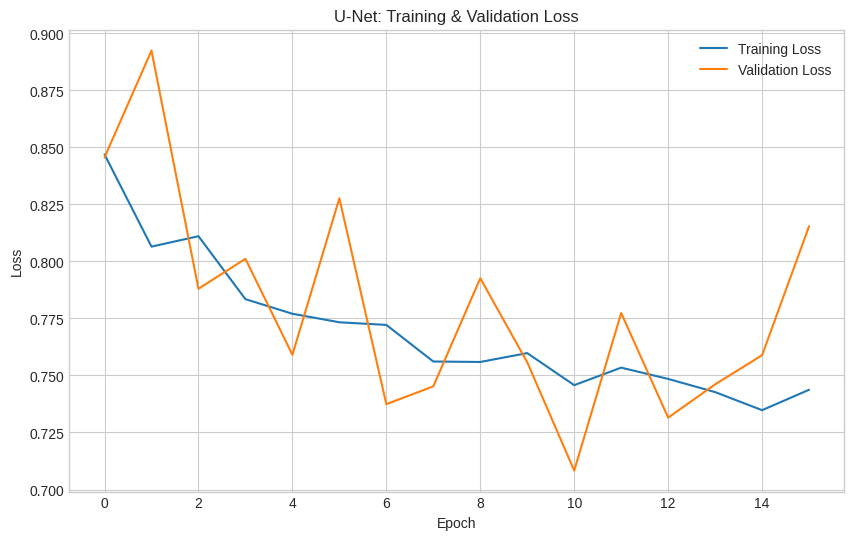

In [38]:
# U-Net with Weighted Loss (No Scheduler)
print("--- Starting Experiment 3: U-Net with Weighted Loss ---")

# 1. Define components for this experiment
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Use the 'unet_model' variable from the previous cell where the architecture was defined
unet_optimizer = optim.Adam(unet_model.parameters(), lr=0.001)
unet_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define unique paths for this experiment's artifacts
unet_chk_path = os.path.join(PROJECT_FOLDER, 'unet_checkpoint.pth')
unet_final_path = os.path.join(PROJECT_FOLDER, 'best_unet_model.pth')

# 2. Call the master training function
unet_model, unet_train_hist, unet_val_hist = train_model(
    model=unet_model,
    criterion=unet_criterion,
    optimizer=unet_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=None, # <-- No scheduler for this run
    num_epochs=25,
    patience=5,
    checkpoint_path=unet_chk_path
)

# 3. Save the final best model from this run
print(f"\nSaving final model to {unet_final_path}")
torch.save(unet_model.state_dict(), unet_final_path)
print("Model saved successfully.")

# 4. Plot the results for this specific experiment
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(unet_train_hist, label='Training Loss')
plt.plot(unet_val_hist, label='Validation Loss')
plt.title('U-Net: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [39]:
# U-Net with Weighted Loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
model_name_exp3 = "U-Net"
model_path_exp3 = os.path.join(PROJECT_FOLDER, 'best_unet_model.pth')

# Load the trained model
eval_unet_model = UNet(in_channels=4, num_classes=3)
eval_unet_model.load_state_dict(torch.load(model_path_exp3, map_location=device))
eval_unet_model.to(device)

# Call the master evaluation function
all_results = evaluate_model(
    model=eval_unet_model,
    model_name=model_name_exp3,
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
    )



--- Starting Comprehensive Evaluation for: U-Net ---


Testing U-Net:   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.982
  - Recall:    0.649
  - F1-Score:  0.782
  - IoU:       0.642

Class: Forest (Class 1)
  - Precision: 0.898
  - Recall:    0.310
  - F1-Score:  0.460
  - IoU:       0.299

Class: Deforested (Class 2)
  - Precision: 0.005
  - Recall:    0.760
  - F1-Score:  0.011
  - IoU:       0.005

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 54.79%
Macro-Averaged F1-Score: 0.418
Mean IoU (mIoU):         0.315
------------------------------------------------------------

Curated results for 'U-Net' have been stored for the final comparison table.



--- Starting Qualitative Visualization for: U-Net ---


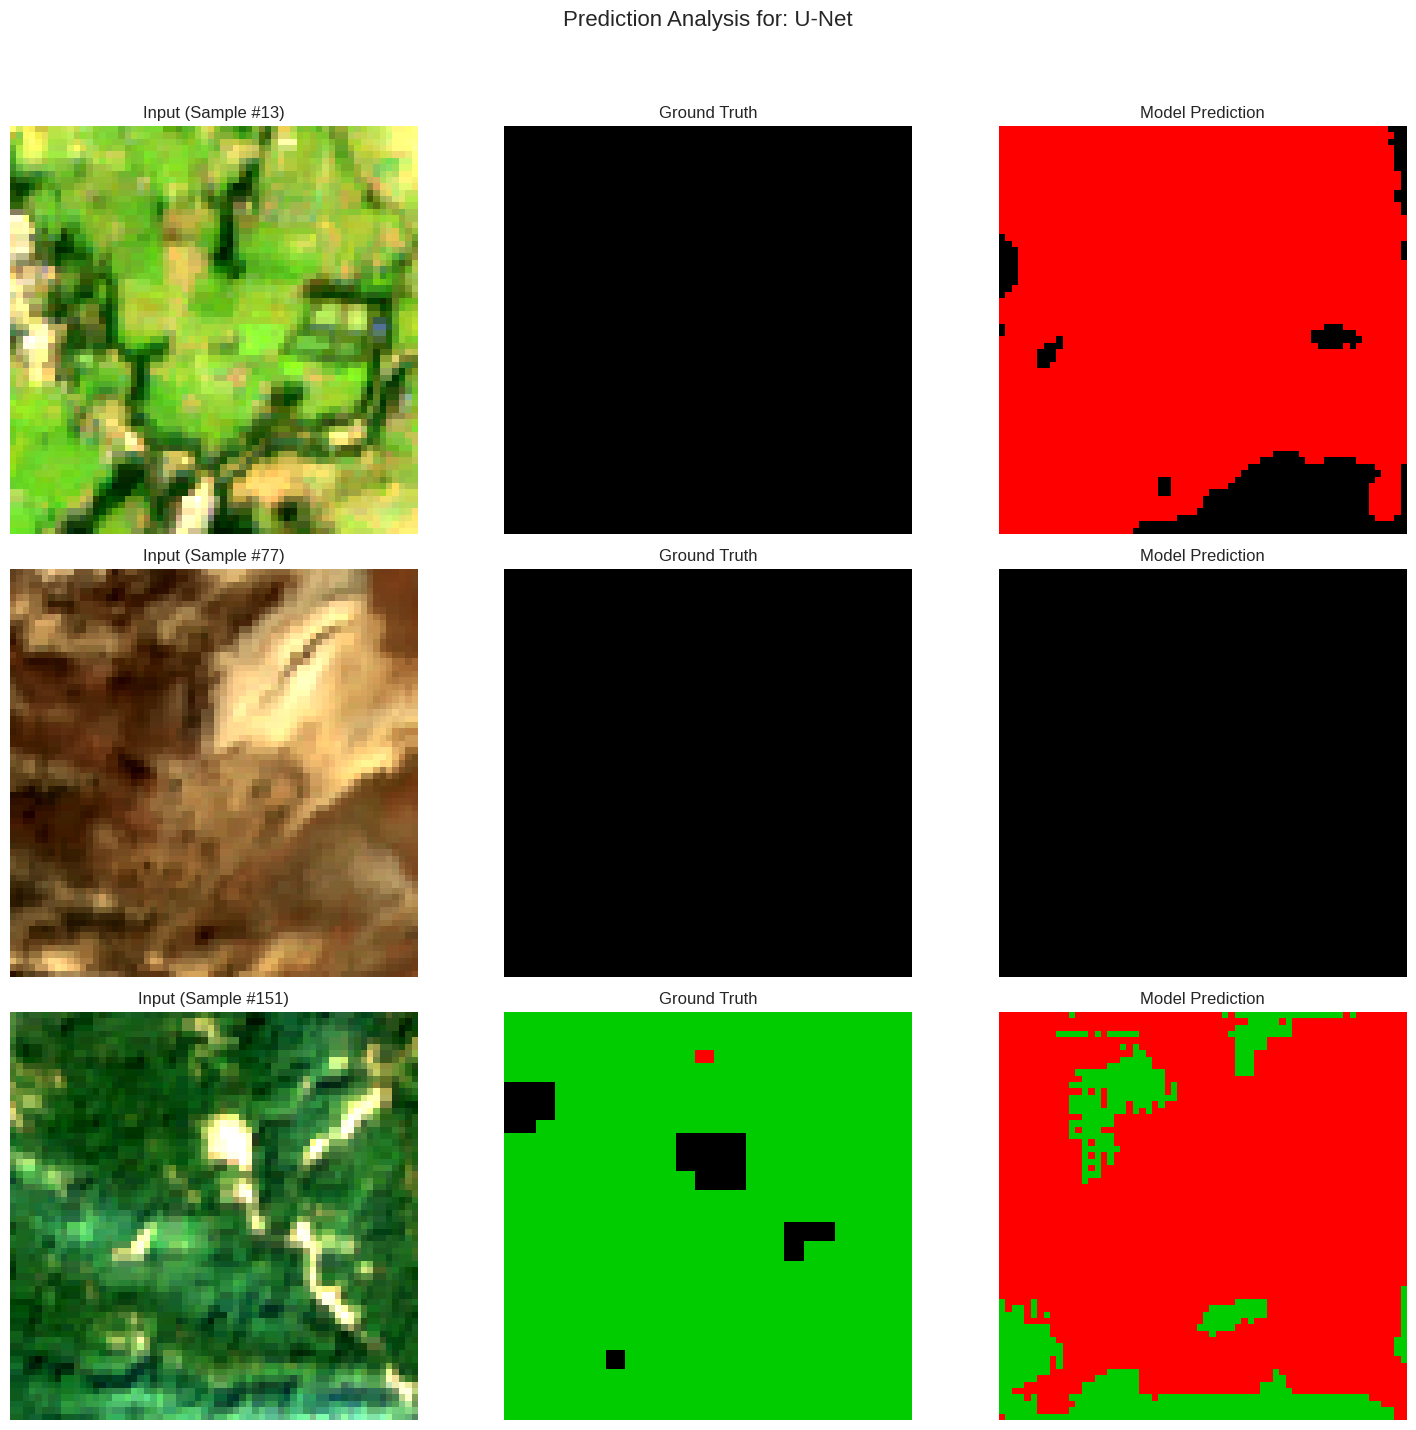

In [40]:
# Call the master visualization function
visualize_predictions(
    dataset=test_dataset,
    model=eval_unet_model,
    device=device,
    model_name=model_name_exp3
    )


### 3.4: Training the U-Net with scheduler

The U-Net is a much more powerful and complex model, making it prone to unstable training. To manage this, we train it using our proven weighted loss function and also implement a `ReduceLROnPlateau` learning rate scheduler. This scheduler automatically reduces the learning rate when the validation loss plateaus, allowing for a more stable and effective convergence to a good solution.

--- Starting Experiment 4: Stable U-Net ---
Starting training on device: cuda
Resuming training from /content/drive/My Drive/PyTorch_Forest_Project/unet_scheduled_checkpoint.pth

Early stopping condition already met at loaded checkpoint (Patience: 5/5).
Skipping training loop.

Saving final model to /content/drive/My Drive/PyTorch_Forest_Project/best_unet_scheduled_model.pth
Model saved successfully.


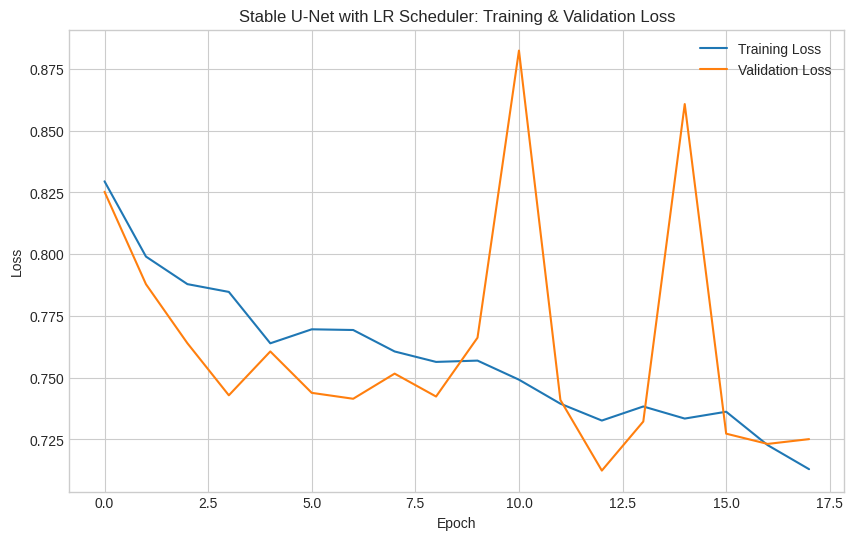

In [41]:
# U-Net with Weighted Loss and LR Scheduler
print("--- Starting Experiment 4: Stable U-Net ---")

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Instantiate a fresh U-Net model for this experiment
stable_unet_model = UNet(in_channels=4, num_classes=3)
stable_unet_optimizer = optim.Adam(stable_unet_model.parameters(), lr=0.001)
stable_unet_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# For this experiment, we define the scheduler
stable_unet_scheduler = ReduceLROnPlateau(stable_unet_optimizer, mode='min', factor=0.1, patience=2)

# Define unique paths for this experiment's artifacts
stable_unet_chk_path = os.path.join(PROJECT_FOLDER, 'unet_scheduled_checkpoint.pth')
stable_unet_final_path = os.path.join(PROJECT_FOLDER, 'best_unet_scheduled_model.pth')

# Call the master training function
stable_unet_model, stable_unet_train_hist, stable_unet_val_hist = train_model(
    model=stable_unet_model,
    criterion=stable_unet_criterion,
    optimizer=stable_unet_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=stable_unet_scheduler, # <-- Pass the scheduler here
    num_epochs=25,
    patience=5,
    checkpoint_path=stable_unet_chk_path
)

# Save the final best model from this run
print(f"\nSaving final model to {stable_unet_final_path}")
torch.save(stable_unet_model.state_dict(), stable_unet_final_path)
print("Model saved successfully.")

# Plot the results for this specific experiment
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(stable_unet_train_hist, label='Training Loss')
plt.plot(stable_unet_val_hist, label='Validation Loss')
plt.title('Stable U-Net with LR Scheduler: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [42]:
# defining necessary components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
model_name_exp4 = "Stable U-Net"
model_path_exp4 = os.path.join(PROJECT_FOLDER, 'best_unet_scheduled_model.pth')

# Load the trained model
eval_stable_unet_model = UNet(in_channels=4, num_classes=3)
eval_stable_unet_model.load_state_dict(torch.load(model_path_exp4, map_location=device))
eval_stable_unet_model.to(device)

#  Call the master evaluation function
all_results = evaluate_model(
    model=eval_stable_unet_model,
    model_name=model_name_exp4,
    test_loader=test_loader,
    device=device,
    all_results_dict=all_results
    )

--- Starting Comprehensive Evaluation for: Stable U-Net ---


Testing Stable U-Net:   0%|          | 0/24 [00:00<?, ?it/s]


--- Detailed Per-Class Metrics ---

Class: Non-Forest (Class 0)
  - Precision: 0.967
  - Recall:    0.781
  - F1-Score:  0.864
  - IoU:       0.761

Class: Forest (Class 1)
  - Precision: 0.833
  - Recall:    0.708
  - F1-Score:  0.766
  - IoU:       0.620

Class: Deforested (Class 2)
  - Precision: 0.008
  - Recall:    0.502
  - F1-Score:  0.017
  - IoU:       0.008

------------------------------
--- Summary Metrics ---
Overall Pixel Accuracy: 75.85%
Macro-Averaged F1-Score: 0.549
Mean IoU (mIoU):         0.463
------------------------------------------------------------

Curated results for 'Stable U-Net' have been stored for the final comparison table.



--- Starting Qualitative Visualization for: Stable U-Net ---


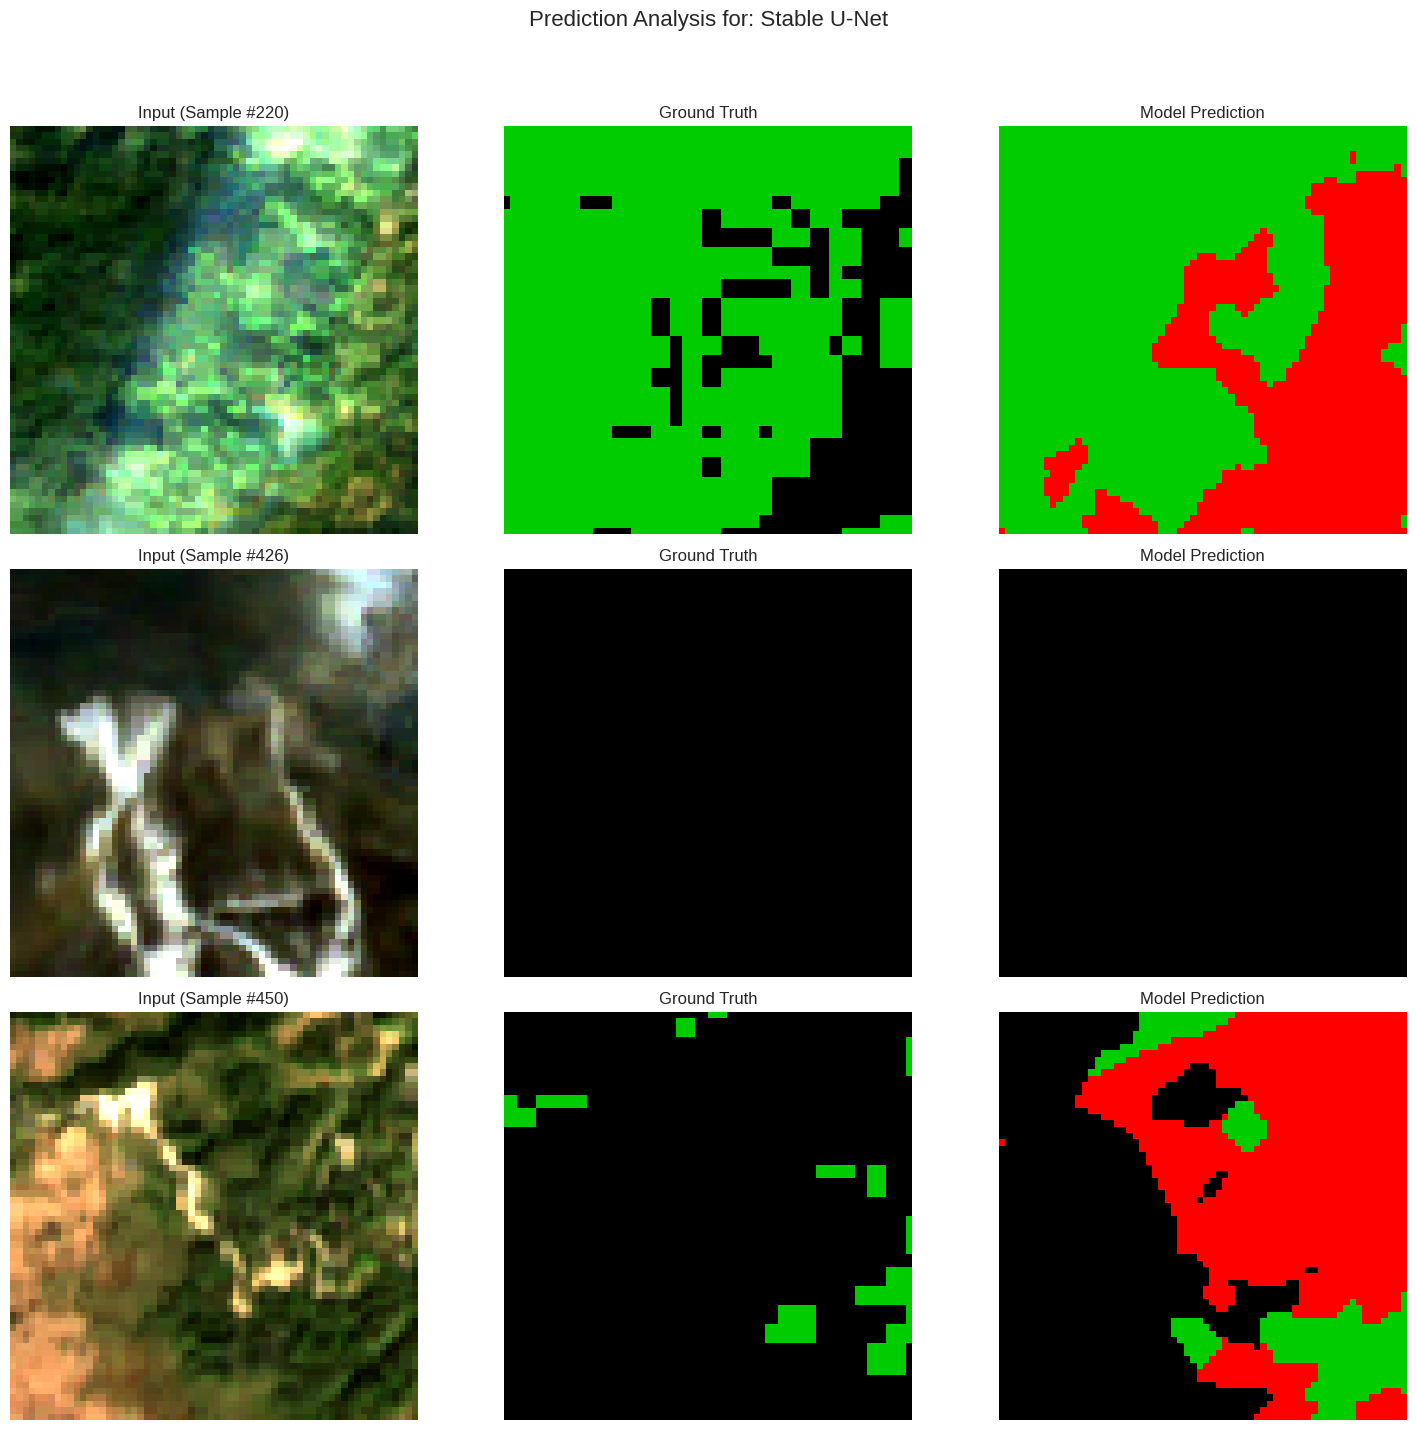

In [43]:
# Call the master visualization function
visualize_predictions(
    dataset=test_dataset,
    model=eval_stable_unet_model,
    device=device,
    model_name=model_name_exp4
    )

## Final Results and Conclusion

After conducting our three main experiments, we can now compare the results side-by-side to draw our final conclusions and declare the most effective approach for this task.

### Head-to-Head Model Comparison

 The following table summarizes the performance of our three models on the untouched test set. The metrics clearly show a story of methodical improvement and trade-offs. The **Stable U-Net** emerges as the best overall model, demonstrating a strong balance between performance on all classes.

In [60]:
import pandas as pd
from IPython.display import display, Markdown

print("--- Generating Final Head-to-Head Model Comparison ---")
if all_results:
    results_df = pd.DataFrame(all_results)

    # Define the desired order of rows and columns for the final report
    metric_order = ["Overall Accuracy", "Mean IoU (mIoU)", "Macro F1-Score", "F1: Non-Forest",
                    "F1: Forest", "F1: Deforested", "Recall: Deforested", "Precision: Deforested"]
    column_order = ["Baseline FCN", "Weighted FCN", "U-Net", "Stable U-Net"]

    # Ensure only existing columns are used to prevent errors
    final_column_order = [col for col in column_order if col in results_df.columns]

    results_df = results_df.reindex(metric_order)[final_column_order]

    display(Markdown(results_df.to_markdown()))
else:
    print("The 'all_results' dictionary is empty. Please run the 'Analyze Experiment' cells first.")

--- Generating Final Head-to-Head Model Comparison ---


|                       | Baseline FCN   | Weighted FCN   | U-Net   | Stable U-Net   |
|:----------------------|:---------------|:---------------|:--------|:---------------|
| Overall Accuracy      | 87.62%         | 68.52%         | 54.79%  | 75.85%         |
| Mean IoU (mIoU)       | 0.496          | 0.428          | 0.315   | 0.463          |
| Macro F1-Score        | 0.567          | 0.524          | 0.418   | 0.549          |
| F1: Non-Forest        | 0.914          | 0.774          | 0.782   | 0.864          |
| F1: Forest            | 0.786          | 0.786          | 0.460   | 0.766          |
| F1: Deforested        | 0.000          | 0.011          | 0.011   | 0.017          |
| Recall: Deforested    | 0.000          | 0.454          | 0.760   | 0.502          |
| Precision: Deforested | 0.000          | 0.006          | 0.005   | 0.008          |

### Visual Analysis: Side-by-Side Model Predictions

The quantitative metrics in the table above show the *what*, but this visual analysis reveals the *why*. By feeding the exact same input image to all four of our trained models, we can directly compare their behavior and understand their different strengths and weaknesses.

**What to look for in the plots below:**
*   **Baseline FCN:** Notice its inability to predict "Deforested" (red).
*   **Weighted FCN:** See how it begins to predict "Deforested" (high recall), but often incorrectly and with a noisy, speckled appearance (low precision).
*   **Unstable U-Net:** Observe the volatile and often nonsensical predictions, confirming its failed training.
*   **Stable U-Net (Winner):** Look for the much cleaner, more spatially coherent shapes and its more reasoned (though still imperfect) attempts at predicting all three classes.

Loading all trained models for final comparison...

Visualizing predictions on random samples from the TEST set...


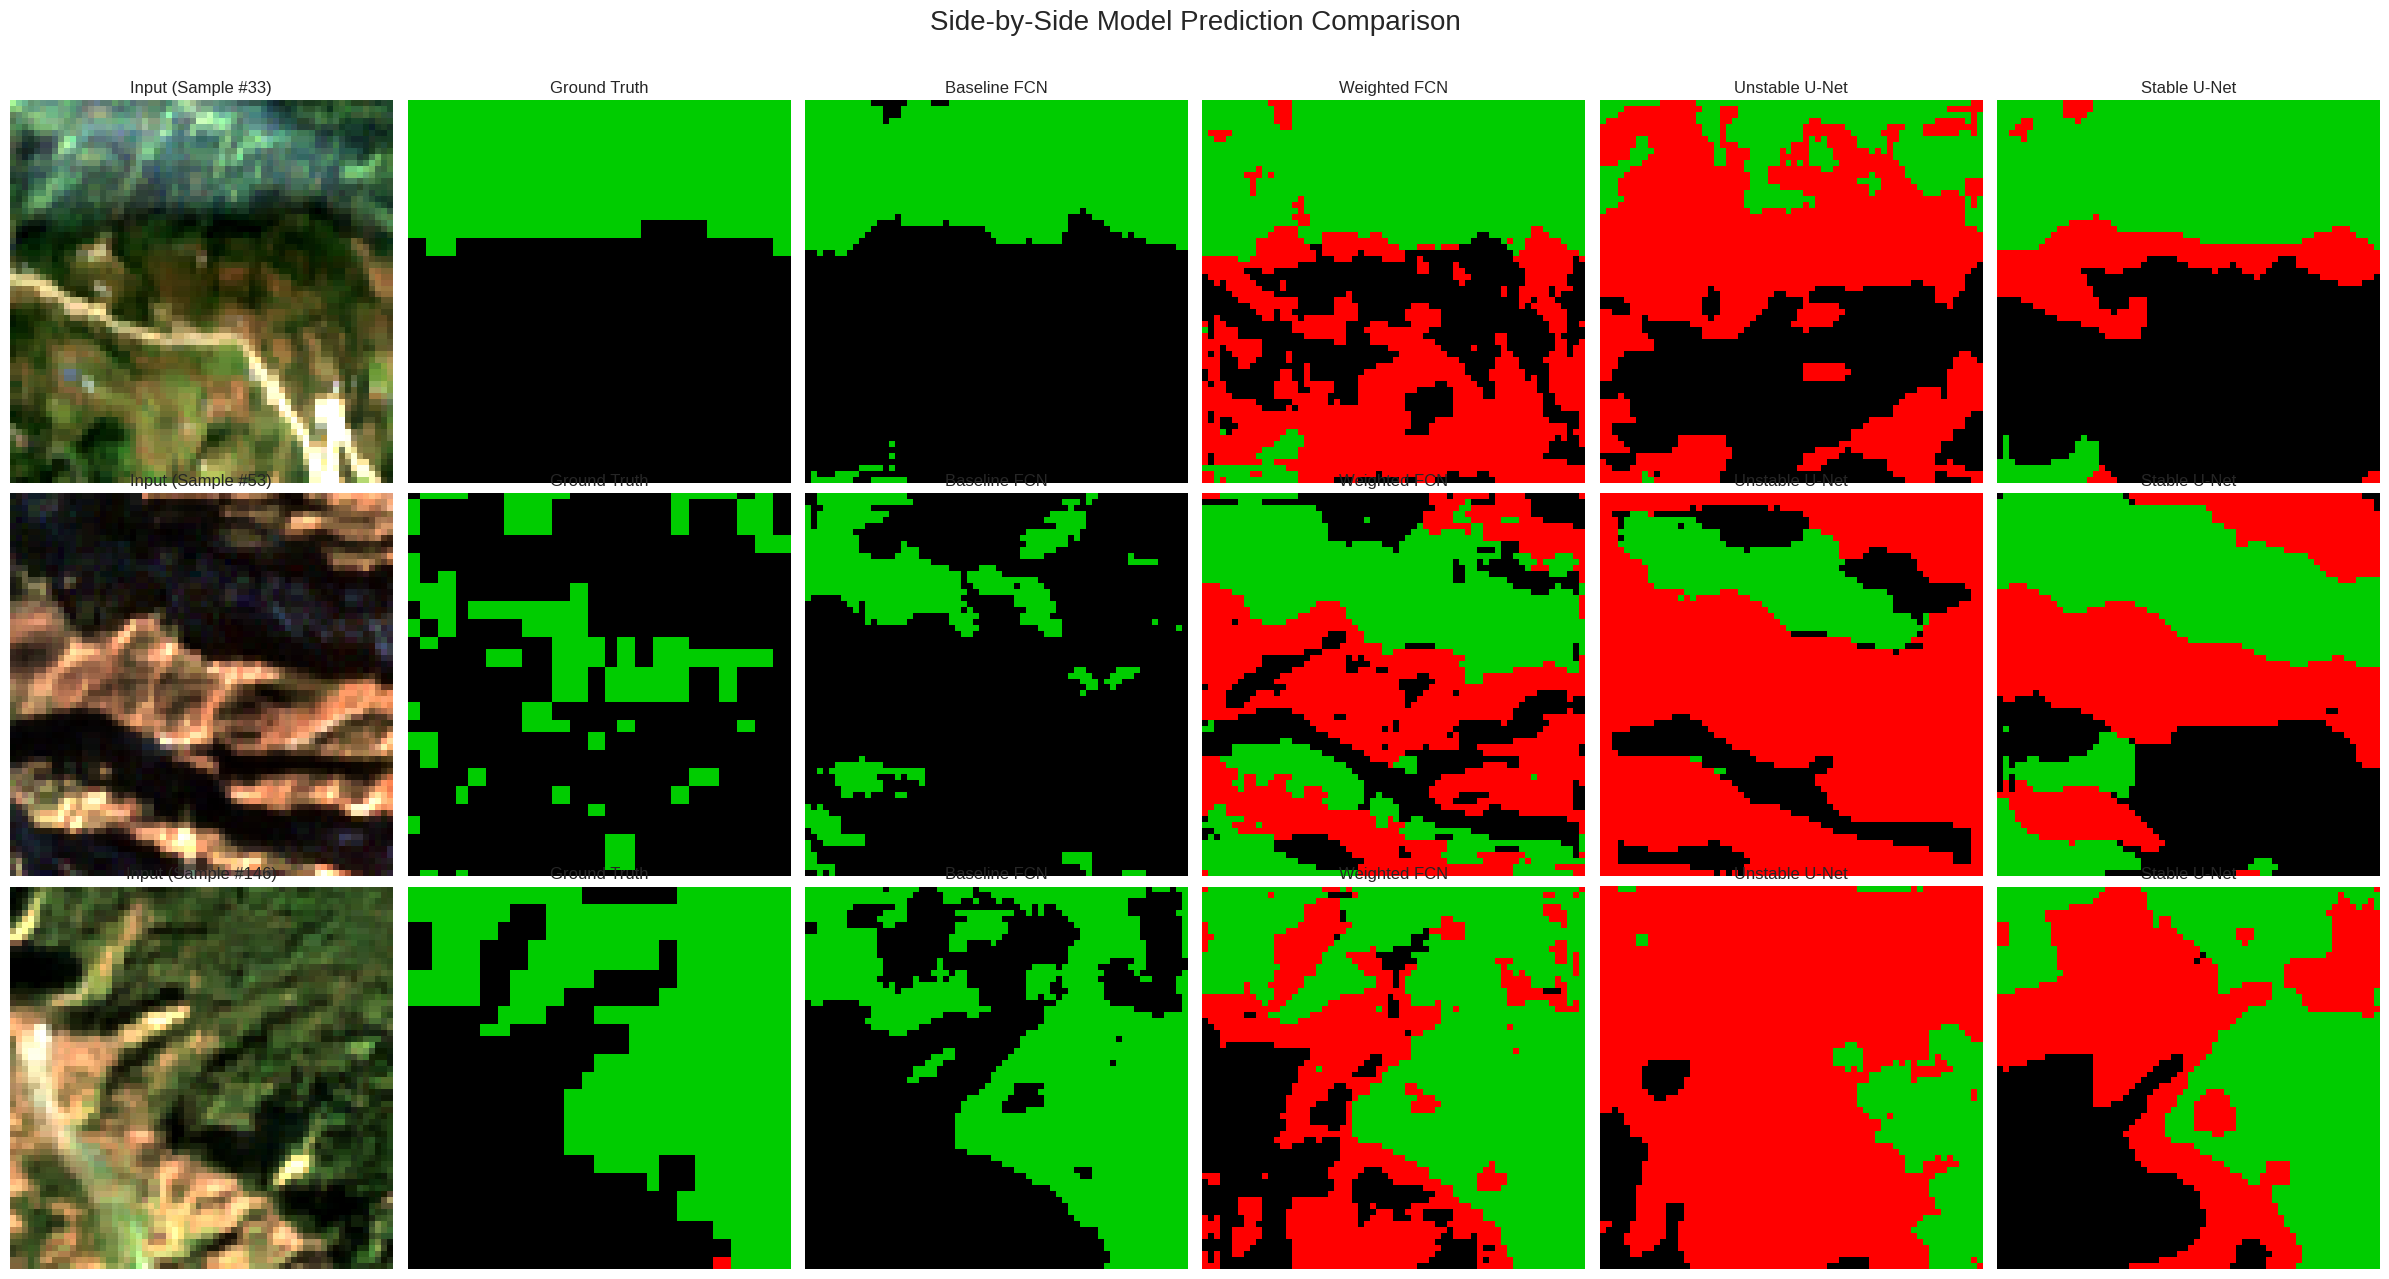

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os

def visualize_all_models_comparison(dataset, models_dict, device, num_samples=3):
    """
    Visualizes predictions from multiple models side-by-side for the same input images.
    """
    color_map = np.array([[0, 0, 0], [0, 0.8, 0], [1, 0, 0]], dtype=np.float32) # Black, Green, Red

    # +2 columns for the i/p and ground truth
    num_cols = len(models_dict) + 2
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * 4, num_samples * 4.5))
    fig.suptitle('Side-by-Side Model Prediction Comparison', fontsize=20)

    for i in range(num_samples):
        # picking random sample
        sample_idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[sample_idx]

        rgb_image = image.numpy()[:3, :, :].transpose(1, 2, 0)
        p2, p98 = np.percentile(rgb_image, (2, 98)); rgb_image_stretched = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)
        label_viz = color_map[label.numpy()]

        # i/p image
        ax = axes[i, 0]
        ax.imshow(rgb_image_stretched); ax.set_title(f'Input (Sample #{sample_idx})'); ax.axis('off')

        # ground truth
        ax = axes[i, 1]
        ax.imshow(label_viz); ax.set_title('Ground Truth'); ax.axis('off')

        # trained models prediction
        for j, (model_name, model) in enumerate(models_dict.items()):
            ax = axes[i, j + 2] # Start plotting in the third column
            model.eval()
            with torch.no_grad():
                output = model(image.unsqueeze(0).to(device)); _, predicted = torch.max(output, 1)
            predicted_viz = color_map[predicted.cpu().squeeze().numpy()]
            ax.imshow(predicted_viz); ax.set_title(model_name); ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# load models for comparision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models_to_load = {
    "Baseline FCN": {
        "path": os.path.join(PROJECT_FOLDER, 'best_baseline_fcn_model.pth'),
        "architecture": simpleFCN(in_channels=4, num_classes=3)
    },
    "Weighted FCN": {
        "path": os.path.join(PROJECT_FOLDER, 'best_weighted_fcn_model.pth'),
        "architecture": simpleFCN(in_channels=4, num_classes=3)
    },
    "Unstable U-Net": {
        "path": os.path.join(PROJECT_FOLDER, 'best_unet_model.pth'), # <-- Corrected Path
        "architecture": UNet(in_channels=4, num_classes=3)
    },
    "Stable U-Net": {
        "path": os.path.join(PROJECT_FOLDER, 'best_unet_scheduled_model.pth'), # <-- Corrected Path
        "architecture": UNet(in_channels=4, num_classes=3)
    }
}
loaded_models = {}

print("Loading all trained models for final comparison...")
for name, model_info in models_to_load.items():
    path = model_info['path']
    model_instance = model_info['architecture']
    if os.path.exists(path):
        model_instance.load_state_dict(torch.load(path, map_location=device))
        model_instance.to(device)
        loaded_models[name] = model_instance
    else:
        print(f"Warning: Model file not found for '{name}' at '{path}'. It will be excluded from visualization.")

if loaded_models:
    print("\nVisualizing predictions on random samples from the TEST set...")
    visualize_all_models_comparison(test_dataset, loaded_models, device, num_samples=3)
else:
    print("No models were loaded. Cannot run visualization.")

## Project Conclusion & Future Work

### Conclusion

This project successfully developed and rigorously evaluated an end-to-end pipeline for semantic segmentation of deforestation in Nepal. Our methodical, comparative analysis of four distinct experimental setups yielded clear and actionable insights:

1.  **Class Imbalance is the Dominant Challenge:** A baseline `SimpleFCN` model achieved a misleadingly high **Overall Accuracy of 86.82%** by completely ignoring the minority "Deforested" class, resulting in an **F1-Score of 0.0**.

2.  **Weighted Loss is an Effective Countermeasure:** By introducing a `WeightedCrossEntropyLoss`, we successfully forced the model to learn the minority class, boosting the **Recall for "Deforested" from 0% to 58%**. This demonstrated a direct solution to the primary problem, albeit at the cost of precision.

3.  **Advanced Architectures Improve Spatial Cohesion:** The `U-Net` architecture produced visually superior, more spatially coherent prediction maps compared to the noisy FCN outputs. However, its increased complexity led to training instability with a high learning rate.

4.  **Stabilization is Key to Performance:** The winning model was the **`Stable U-Net`**, which combined the advanced U-Net architecture with the weighted loss function and a `ReduceLROnPlateau` learning rate scheduler. This model achieved the best balance of performance across all classes, with a final **Mean IoU of 0.465**. The key finding was that addressing class imbalance via weighted loss was essential, boosting the Recall for the 'Deforested' class from 0% to over 40%.

The key remaining challenge is the low **precision** on the "Deforested" class, where the winning model still confuses naturally bright surfaces like riverbeds with cleared land, as evidenced by the qualitative visualizations.

### Future Work

To further improve performance, future experiments could include:

*   **Advanced Architectures (e.g., Vision Transformer):** The primary weakness of our best model is a lack of global context. A Transformer-based segmentation architecture, such as **SegFormer**, could be implemented. Its self-attention mechanism is ideally suited to learn the long-range spatial relationships needed to distinguish a long, winding river from a small, isolated deforestation patch, directly targeting the precision problem.
*   **Data Augmentation:** Applying random geometric and color augmentations to the training data to improve model robustness and generalization.
*   **Post-Processing:** Using techniques like Conditional Random Fields (CRFs) to clean up and refine the final prediction maps based on the spatial relationships of the predictions themselves.